In [1]:
import pandas as pd
import numpy as np


events = pd.read_csv('events.csv')
ginf= pd.read_csv('ginf.csv')
total_data = pd.merge(events, ginf, how='right', on = 'id_odsp')
total_data = total_data[total_data['adv_stats']]
total_data = total_data[np.isfinite(total_data['time'])]
total_data['home_score'] =0
total_data['away_score'] =0
total_data['home_score'] = np.where((total_data.is_goal == 1) & (total_data['ht'] == total_data.event_team), 1, 0)
total_data['away_score'] = np.where((total_data.is_goal == 1) & (total_data['at'] == total_data.event_team), 1, 0)
total_data['Home_win'] = np.where((total_data.fthg > total_data.ftag),1, 0)
total_data['Away_win'] = np.where((total_data.ftag > total_data.fthg),1, 0)
total_data['Draw_win'] = np.where((total_data.ftag == total_data.fthg),1, 0)
############## handling each features individually #################
winFeatures =['id_odsp','time','home_score','away_score']
winDf= total_data[winFeatures].drop_duplicates()
winDf = winDf.loc[(winDf.home_score != 0) | (winDf.away_score != 0) ]
oddsFeatures = ['id_odsp','odd_a','odd_h']
oddsDf= total_data[oddsFeatures].drop_duplicates()
overallwinFeatures = ['id_odsp','Home_win','Away_win']
overall_win= total_data[overallwinFeatures].drop_duplicates()
####################################################################

#############Common time and id df#################################
one_to_hundred = pd.Series(range(0,101,1))
game_time_series = pd.concat([one_to_hundred]*9074, ignore_index=True)
game_unique_ids = total_data.id_odsp.unique()
game_unique_idseries = np.repeat(game_unique_ids, 101)

####################################################################
################      Merging Data     #############################
Actual_dataI = pd.DataFrame({'time' : game_time_series, 'id_odsp' : game_unique_idseries})
Actual_dataI = pd.merge(Actual_dataI, winDf, how='left', on=['time','id_odsp'] )
Actual_dataI = Actual_dataI.fillna(0)
Actual_dataI = pd.merge(Actual_dataI, oddsDf, how='left', on=['id_odsp'] )
Actual_dataI = pd.merge(Actual_dataI, overall_win, how='left', on=['id_odsp'] )

In [2]:
###########  Extract all the rows for wining team ######################
temp1_Actual_dataII = Actual_dataI[Actual_dataI.Home_win == 1]
temp1_Actual_dataII = temp1_Actual_dataII.drop(['odd_a','Home_win','Away_win'], axis=1)
temp1_Actual_dataII.rename(columns={'odd_h': 'odd'}, inplace=True)
temp1_Actual_dataII['winningTeam'] = 1

temp2_Actual_dataII = Actual_dataI[Actual_dataI.Away_win == 1]
temp2_Actual_dataII = temp2_Actual_dataII.drop(['odd_h','Home_win','Away_win'], axis=1)
temp2_Actual_dataII.rename(columns={'odd_a': 'odd'}, inplace=True)
temp2_Actual_dataII['winningTeam'] = 2

Actual_windataII = pd.concat([temp1_Actual_dataII, temp2_Actual_dataII], axis =0)
Actual_windataII = Actual_windataII.reset_index()
groupedItem = Actual_windataII.groupby('id_odsp')
Actual_windataII['Home_scoree'] = groupedItem.home_score.cumsum()
groupedItem = Actual_windataII.groupby('id_odsp')
Actual_windataII['Away_scoree'] = groupedItem.away_score.cumsum()
Actual_windataII['goal_diff'] =  np.where((Actual_windataII['winningTeam'] == 1), Actual_windataII['Home_scoree'] - Actual_windataII['Away_scoree'], 
                                          Actual_windataII['Away_scoree'] - Actual_windataII['Home_scoree'])
del Actual_windataII['index']
################# Extract data for losing team #####################
# temp1_Actual_dataII = Actual_dataI[(Actual_dataI.Home_win == 0) & (Actual_dataI.Away_win == 1)]
# temp1_Actual_dataII = temp1_Actual_dataII.drop(['odd_a','Home_win','Away_win'], axis=1)
# temp1_Actual_dataII.rename(columns={'odd_h': 'odd'}, inplace=True)

# temp2_Actual_dataII = Actual_dataI[(Actual_dataI.Away_win == 0) & (Actual_dataI.Home_win == 1)]
# temp2_Actual_dataII = temp2_Actual_dataII.drop(['odd_h','Home_win','Away_win'], axis=1)
# temp2_Actual_dataII.rename(columns={'odd_a': 'odd'}, inplace=True)
# Actual_losedataII = pd.concat([temp1_Actual_dataII, temp2_Actual_dataII], axis =0)
# Actual_losedataII = Actual_losedataII.reset_index()

In [3]:
print()
print(Actual_windataII['odd'].min())
len(Actual_windataII.id_odsp.unique())


1.06


6765

In [4]:
df = Actual_windataII.copy()
def find_win_game(start_time, end_time):
    selected = df.loc[(((df.home_score == 1) & (df.winningTeam == 1)) |
                      ((df.away_score == 1) & (df.winningTeam == 2))) & 
                      ((df.time >= start_time) & (df.time < end_time))]
    return len(selected.id_odsp.unique())   

total_win_match = []

#start_time_list = [0, 26, 46, 76, 86, 91, 96]
#end_time_list = [25, 45, 75, 85, 90, 95, 100]

for i in range(0, 101):
    total_win_match.append(find_win_game(i, i+1))

print(total_win_match)


def find_win_game_second(start_time, end_time):
    selected = df.loc[((df.home_score == 1) | (df.away_score == 1)) &
                       (df.time >= start_time) & (df.time < end_time)]
    return len(selected.id_odsp.unique())   

win_match_second = []

for i in range(0, 101):
    win_match_second.append(find_win_game_second(i, i+1))

print(win_match_second)

total_win_match_c = total_win_match.copy()
win_match_second_c = win_match_second.copy()

total_win_match_c = [1 if x==0 else x for x in total_win_match_c]
win_match_second_c = [1 if x==0 else x for x in win_match_second_c]
print(total_win_match_c)
print(win_match_second_c)

[2, 70, 109, 110, 117, 118, 137, 147, 133, 128, 139, 135, 146, 152, 143, 132, 166, 161, 166, 162, 152, 151, 136, 160, 157, 146, 180, 146, 160, 134, 167, 169, 161, 178, 182, 169, 165, 152, 159, 160, 162, 183, 164, 158, 183, 364, 108, 156, 172, 171, 213, 185, 169, 207, 170, 197, 232, 185, 175, 166, 182, 207, 177, 193, 194, 186, 167, 186, 194, 172, 169, 174, 204, 209, 181, 195, 190, 193, 182, 205, 176, 190, 193, 177, 183, 190, 209, 191, 209, 183, 805, 43, 55, 43, 26, 11, 2, 0, 1, 0, 0]
[4, 94, 134, 145, 155, 155, 173, 181, 166, 168, 179, 170, 192, 188, 184, 174, 193, 189, 197, 201, 189, 187, 171, 193, 196, 186, 234, 178, 207, 163, 208, 209, 194, 215, 216, 205, 201, 195, 187, 187, 194, 220, 204, 194, 216, 464, 132, 194, 208, 208, 258, 231, 208, 234, 209, 253, 280, 220, 224, 213, 218, 247, 225, 236, 234, 227, 218, 226, 224, 217, 216, 213, 249, 247, 214, 243, 234, 233, 224, 258, 223, 237, 243, 219, 223, 233, 257, 234, 249, 231, 963, 51, 64, 49, 31, 15, 2, 0, 1, 0, 0]
[2, 70, 109, 110, 117, 1

In [5]:
df.goal_diff.max()

8.0

In [7]:
def find_win_game_goal_diff(start_time, end_time, goal_diff_check):
    selected = df.loc[(((df.home_score == 1) & (df.winningTeam == 1)) |
                      ((df.away_score == 1) & (df.winningTeam == 2))) & 
                      ((df.time >= start_time) & (df.time < end_time)) &
                      (df.goal_diff == goal_diff_check)]
    return len(selected.id_odsp.unique())

#consider all the matches
def find_win_game_second_goal_diff(start_time, end_time, goal_diff_check):
    selected = df.loc[((df.home_score == 1) | (df.away_score == 1)) &
                       (df.time >= start_time) & (df.time < end_time) &
                       (df.goal_diff == goal_diff_check)]
    return len(selected.id_odsp.unique()) 

win_match_goal_diff = [[] for x in range(12)]
win_match_second_goal_diff = [[] for x in range(12)]

# win_match_goal_diff = [[]]
# win_match_second_goal_diff = [[]]

#goal_diff_range = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

for j in range (-3, 9):
    for i in range(0, 101):
        win_match_goal_diff[j+3].append(find_win_game_goal_diff(i, i+1, j))

print(win_match_goal_diff)  

for j in range(-3, 9):
    for i in range(0, 101):
        win_match_second_goal_diff[j+3].append(find_win_game_second_goal_diff(i, i+1, j))

#print("Hello")
print(win_match_second_goal_diff)

# total_win_match_c = total_win_match.copy()
# win_match_second_c = win_match_second.copy()

# total_win_match_c = [1 if x==0 else x for x in total_win_match_c]
# win_match_second_c = [1 if x==0 else x for x in win_match_second_c]
# print(total_win_match_c)
# print(win_match_second_c)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 4, 0, 0, 1, 2, 3, 1, 1, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 4, 1, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 2, 1, 6, 4, 4, 2, 6, 8, 6, 14, 6, 8, 11, 17, 14, 14, 15, 12, 15, 13, 16

In [9]:
import seaborn as sns
import matplotlib.axes as ax
import matplotlib.pyplot as plt

In [11]:
def find_goal(start_time, end_time):
    selected = df.loc[((df.home_score == 1) | (df.away_score == 1)) &
                       (df.time >= start_time) & (df.time < end_time)]
    return len(selected)   

goal_info = []

for i in range(0, 101):
    goal_info.append(find_goal(i, i+1))

In [13]:
print(goal_info)

[4, 94, 134, 145, 155, 155, 173, 181, 166, 168, 179, 170, 192, 188, 184, 174, 193, 189, 197, 201, 189, 187, 171, 193, 196, 186, 234, 178, 207, 163, 208, 209, 194, 215, 216, 205, 201, 195, 187, 187, 194, 220, 204, 194, 216, 466, 132, 194, 208, 208, 258, 231, 208, 234, 209, 253, 280, 220, 224, 213, 218, 247, 225, 236, 234, 227, 218, 226, 224, 217, 216, 213, 249, 247, 214, 243, 234, 233, 224, 258, 223, 237, 243, 219, 223, 233, 257, 234, 249, 231, 987, 51, 64, 49, 31, 15, 2, 0, 1, 0, 0]


In [18]:
import numpy as np
goal_info_array = np.asarray(goal_info)

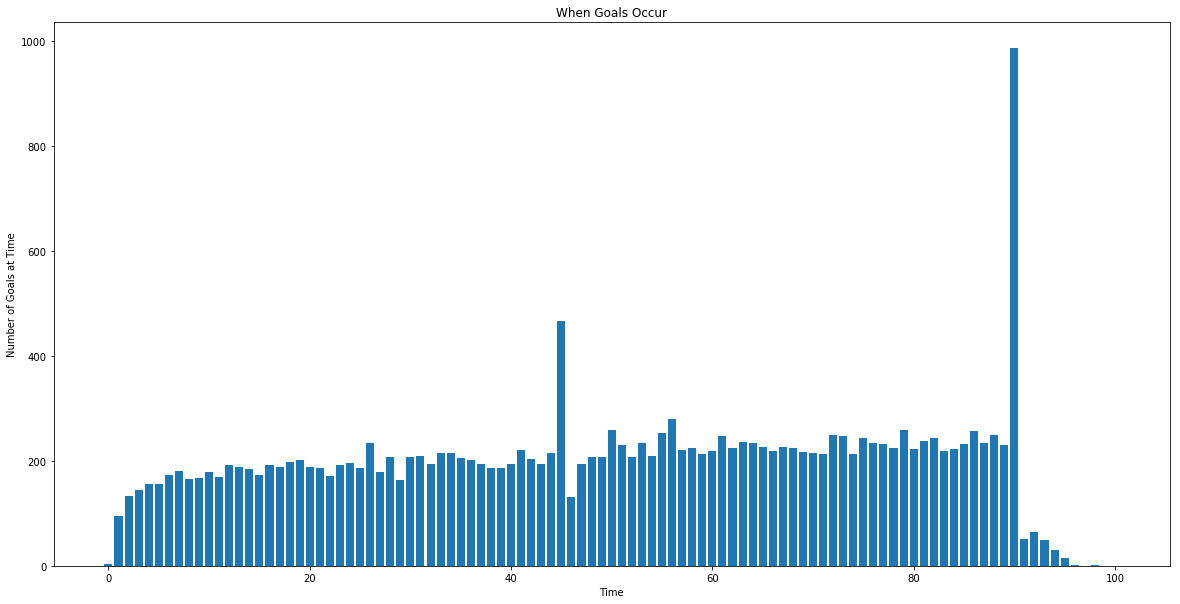

In [26]:
#%matplotlib inline
plt.figure(figsize=(20, 10))
plt.bar(range(len(goal_info)), goal_info)
plt.xlabel("Time")
plt.ylabel("Number of Goals at Time")
plt.title("When Goals Occur")
plt.show()

In [8]:
print(len(win_match_goal_diff))
print(len(win_match_second_goal_diff))
[len(x) for x in win_match_goal_diff]

12
12


[101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]

In [30]:
probb = [[] for x in range(12)]
for j in range (-3, 9):
    for i in range(0, 101):
        if win_match_second_goal_diff[j+3][i] == 0:
            probb[j+3].append(0)
        else:        
            probb[j+3].append(win_match_goal_diff[j+3][i] / win_match_second_goal_diff[j+3][i])


In [31]:
dff = df.copy()
previous_probb = 0
dff.goal_diff = dff.goal_diff.astype(np.int64)
dff.goal_diff.dtype
def findPP(r):
    global previous_probb
    global probb
    if r['time'] ==0:
        previous_probb = 1/r['odd']
    if r['home_score'] == 1 and r['winningTeam'] == 1:
        prob = probb[r['goal_diff'] + 3][r['time']]
    elif r['away_score'] == 1 and r['winningTeam'] == 2:
        prob = probb[r['goal_diff'] + 3][r['time']]
    else:
        prob = previous_probb
    previous_probb = prob
    return prob
dff['prob'] = dff.apply(lambda row: findPP(row),axis = 1)

In [48]:
import math
from sklearn import preprocessing
d = Actual_windataII.copy()

def sigmoid(x):
    return 1/(1+math.exp(-x))

def checkInterval(time):
    if time >= 0 and time <=25:
        return 0.8645
    elif time > 25 and time <=45:
        return 0.8819
    elif time > 45 and time <=75:
        return 0.9139
    elif time > 75 and time <=85:
        return 0.8403
    elif time > 85 and time <=90:
        return 0.8464
    elif time > 90 and time <=95:
        return 0.87
    elif time >95 and time <= 100:
        return 1

def checkProb(time):
    return (total_win_match_c[time] / win_match_second_c[time])

findTime = lambda time: checkInterval(time)
# A = 0
# K = 1
# Q = 0.5
# C = 1
# def getXValue(r):
#     if (r['goal_diff'] == 0 and r['time'] > 90):
#         return (10 * r['goal_diff'] + 1/r['odd'])/ (101 - findTime(r['time']))
#     else:
#         return (10 * r['goal_diff'] + 1/r['odd'])/ (90 - findTime(r['time']))
    
# def findProbability(r): 
#     if r['goal_diff'] > 0  and r['time'] >= 90:
#         return 1
#     else:
#         return A + (K-A)/((C- (Q *math.exp(-getXValue(r))))**(0.5))


def normalizeOdd(r, mini, maxi):
    return (r - mini) / (maxi - mini)


def normalizerr(x):
    min_max_scalar = preprocessing.MinMaxScaler()
    return min_max_scalar.fit_transform(x)
    

# def findProbability(r):
#     global const
#     global previous_goal_diff 
#     if r['time'] == 0:
#         previous_goal_diff = 0
#     if r['goal_diff'] -  previous_goal_diff != 0 and r['time'] > 90:
#         return   const/r['odd'] + (const*(r['goal_diff'] -  previous_goal_diff)/ (101 - findTime(r['time'])))
#     elif r['goal_diff'] -  previous_goal_diff == 0 and r['time'] > 90 :
#         return   const/r['odd'] + ((0.1 / (101 - findTime(r['time']))))
#     elif r['goal_diff'] -  previous_goal_diff != 0 and r['time'] <= 90:
#            return  const/r['odd'] + (const*(r['goal_diff'] -  previous_goal_diff)/ (91 - findTime(r['time'])))
#     elif r['goal_diff'] -  previous_goal_diff == 0 and r['time'] <= 90 :
#         return  const/r['odd'] + ((0.1 / (91 - findTime(r['time']))))
previous_goal_diff = 0
previous_odds = 0
const = 50
def findProbability(r):
    global previous_odds
    global const
    global previous_goal_diff 
    if(r['time'] == 0):
        previous_goal_diff =0
        previous_odds = 1/r['odd']
#     if ((88 <= r['time'] <= 90) and r['goal_diff'] > 0):
#         prob = random(r['time'])
#     if (r['time'] <= 90 and  ((r['home_score'] == 1) or (r['away_score'] == 1)) ):
#         prob = ((previous_odds + (r['goal_diff'] - previous_goal_diff))*const) / (91 -findTime(r['time']))
#     elif (r['time'] >90 and  ((r['home_score'] == 1) or (r['away_score'] == 1)) ):
#         prob = (( previous_odds + (r['goal_diff'] - previous_goal_diff))*const) / (101 -findTime(r['time']))
    if (r['time'] > 85 and r['goal_diff'] >= 1):
        previous_odds = previous_odds + (70/(101 - checkProb(r['time'])))
    if (((r['home_score'] == 1) or (r['away_score'] == 1)) ):
        x1 = ((r['goal_diff'] - previous_goal_diff) / (2 - checkProb(r['time'])))
        x2 = 1 / (10 - checkProb(r['time']))
        prob = previous_odds + ((x1 + x2)/2)
    else :
        if(r['goal_diff'] >= 0):
            prob = previous_odds + (1/(101-checkProb(r['time'])))
        else:
            prob = previous_odds - (1/(101-checkProb(r['time'])))
    previous_odds = prob
    previous_goal_diff = r['goal_diff']
    return prob

dtype('int64')

In [49]:
d['prob'] = d.apply(lambda row : findProbability(row), axis=1)

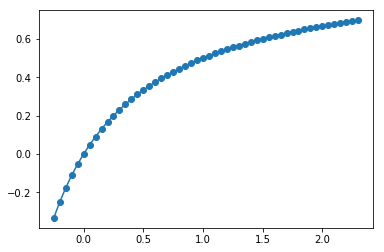

In [50]:
d.loc[:,['time','home_score','goal_diff','prob']].head(101)
import numpy as np
A = 0
K = 1
Q = 0.5
C = 1
def logistic(r):
    return A + (K-A)/((C- (Q *math.exp(-r)))**(0.5))
def rlogistic(r):
    return 1- (2/ (math.exp(r)+1))
def random(r):
    return r /(1+r)
def sigmoid(x):
    return 1/(1+math.exp(-x))
l = [x for x in np.arange(-0.25, 2.35, 0.05)]
k =[]
for a in l:
    k.append(random(a))
plt.plot(l, k, '-o')
plt.show()

In [51]:
d['prob'] = np.where(d['prob'] < 0, 0, d['prob'])
d['normalizedProb'] = d['prob'].apply(lambda row: random(row))

#d['normalizedProb'] = d['prob'].apply(lambda row: random(row))
d.loc[:,['time','home_score','goal_diff','prob','normalizedProb']].head(1001)
print(d.goal_diff.max())

8.0


In [52]:
d['normalizedProb'] = np.where(d['normalizedProb'] < 0, 0, d['normalizedProb'])

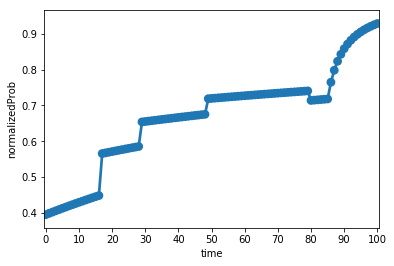

In [53]:
import seaborn as sns
import matplotlib.axes as ax
import matplotlib.pyplot as plt
#pp = pd.Series(range(0,101,2))
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
#ax.scatter(d.time, d.prob, color='r', marker='^', alpha=.4)
sns.pointplot(x = "time", y="normalizedProb",linewidth=0.1, data=d.iloc[0:101,:])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.set_size_inches(18.5, 10.5)
plt.figure(figsize=(20,25))
plt.show()


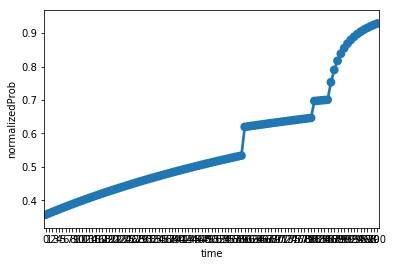

In [54]:
sns.pointplot(x = 'time', y="normalizedProb", data=d.iloc[101:202,:])
plt.show()

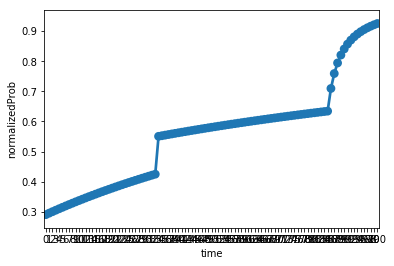

In [55]:
sns.pointplot(x = 'time', y="normalizedProb", data=d.iloc[202:303,:])
plt.show()

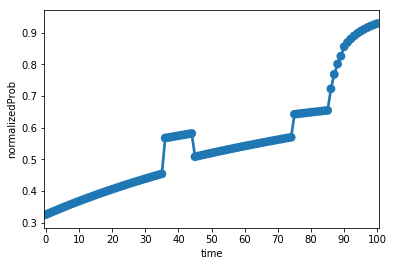

In [56]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()

sns.pointplot(x = 'time', y="normalizedProb", data=d.iloc[303:404,:])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

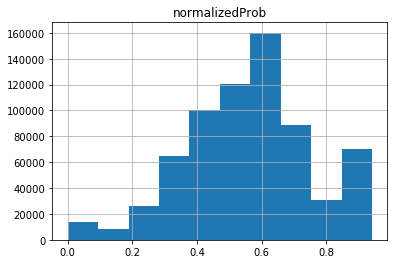

In [57]:
#print(d.normalizedProb)
d.hist(column ='normalizedProb')
plt.show()

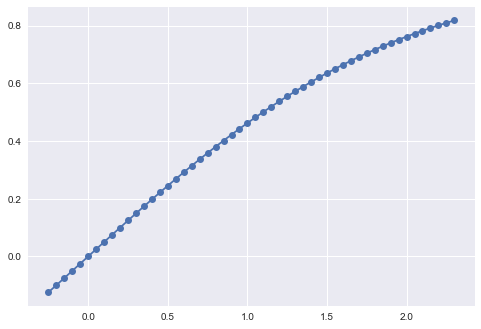

In [214]:
import numpy as np
A = 0
K = 1
Q = 0.5
C = 1
def logistic(r):
    return A + (K-A)/((C- (Q *math.exp(-r)))**(0.5))
def rlogistic(r):
    return 1- (2/ (math.exp(r)+1))
def random(r):
    return r /(1+r)
def sigmoid(x):
    return 1/(1+math.exp(-x))
l = [x for x in np.arange(-0.25, 2.35, 0.05)]
k =[]
for a in l:
    k.append(rlogistic(a))
plt.plot(l, k, '-o')
plt.show()    

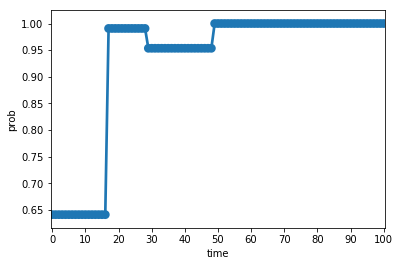

In [32]:
import seaborn as sns
import matplotlib.axes as ax
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#pp = pd.Series(range(0,101,2))
#fig, ax = plt.subplots()
#ax.scatter(d.time, d.prob, color='r', marker='^', alpha=.4)
ax = sns.pointplot(x = "time", y="prob",linewidth=0.1, data=dff.iloc[0:101])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.set_size_inches(18.5, 10.5)
#plt.figure(figsize=(20,25))
plt.show()


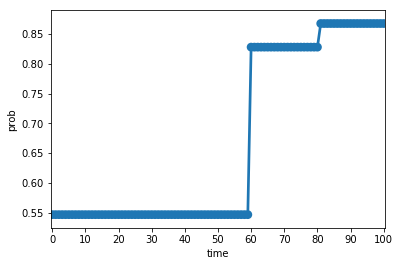

In [33]:
import seaborn as sns
import matplotlib.axes as ax
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#pp = pd.Series(range(0,101,2))
#fig, ax = plt.subplots()
#ax.scatter(d.time, d.prob, color='r', marker='^', alpha=.4)
ax = sns.pointplot(x = "time", y="prob",linewidth=0.1, data=dff.iloc[101:202])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.set_size_inches(18.5, 10.5)
#plt.figure(figsize=(20,25))import seaborn as sns


plt.show()


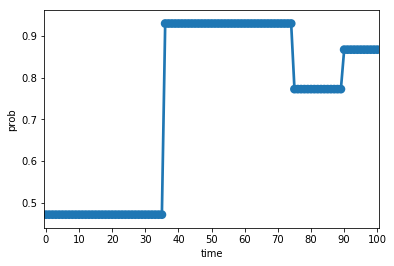

In [34]:
import matplotlib.axes as ax
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#pp = pd.Series(range(0,101,2))
#fig, ax = plt.subplots()
#ax.scatter(d.time, d.prob, color='r', marker='^', alpha=.4)
ax = sns.pointplot(x = "time", y="prob",linewidth=0.1, data=dff.iloc[303:404])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.set_size_inches(18.5, 10.5)
#plt.figure(figsize=(20,25))
plt.show()

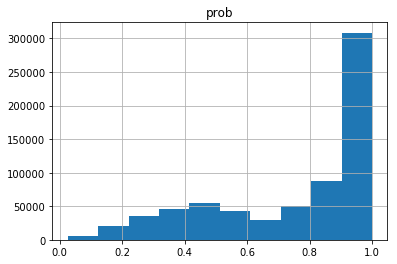

In [35]:
#print(d.normalizedProb)
dff.hist(column ='prob')
plt.show()

In [46]:
df.shape()

TypeError: 'tuple' object is not callable